In [1]:
from lbmpy.session import *
from lbmpy.fieldaccess import *
from lbmpy.advanced_streaming.utility import is_inplace, Timestep
from lbmpy.boundaries import NoSlip, UBB

# Demo: Streaming Patterns

Due to the abstract field access provided by `lbmpy`, it is seamlessly possible to support several different streaming steps for the lattice Boltzmann method. All supported streaming steps can be found in lbmpy.fieldaccess. Essential streaming algorithms are the two `Two-Field-algorithms`, namely the `Pull` and the `Push` step, and four variants of `One-Field-algorithms` (sometimes also refered to as `in-place streaming schemes`). These are called the [AA-Pattern](https://doi.org/10.1109/ICPP.2009.38), the [Esoteric Twist](https://doi.org/10.3390/computation5020019), and its two variants, the [Esoteric Pull and Esoteric Push](https://doi.org/10.3390/computation10060092) scheme.
An essential property of these two categories of streaming schemes is that for `Two-Field-algorithms`, two copies of the PDF vector are needed (because the algorithm is not thread-safe), while the `One-Field-algorithms` only need one PDF vector. Thus they save about 50 % of memory. However, this comes at the cost of slightly higher complexity. The reason is that `One-Field-algorithms` are split into Odd and Even timesteps. Thus two variants of the compute kernels, boundary conditions, etc., need to be implemented. Usually, this states a more significant problem, but due to its high level of abstraction, lbmpy can generate special variants automatically and thus hide most of the complexity completely.


Besides the six above mentioned, more `PdfFieldAccessor` classes are available. However, these are either not combinable with large-scale MPI-distributed simulations (e.g., the `PeriodicTwoFieldsAccessor`) or fulfill only particular purposes like `CollideOnlyInplaceAccessor`.

Let us start by taking a visual look at the different variants.

## Collide In-Place

This special accessor essentially models the absence of a streaming step.
Using it will lead to just executing the collision step on every cell and replacing local pre- with post-collision values.

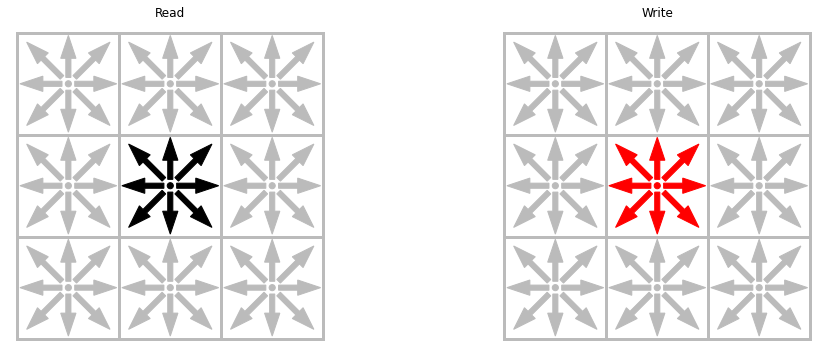

In [2]:
collide_only = CollideOnlyInplaceAccessor()
visualize_pdf_field_accessor(collide_only)

## Pull

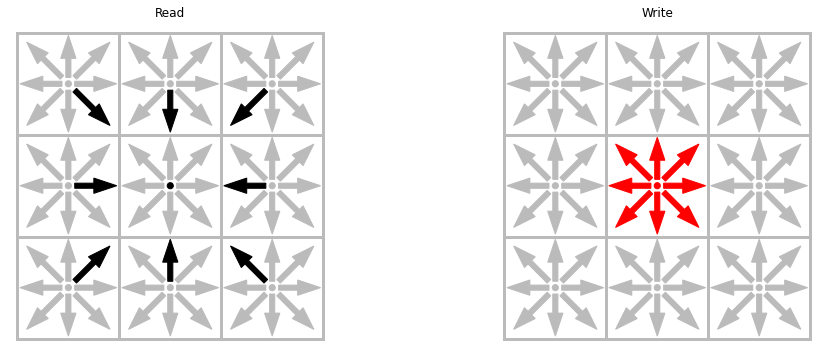

In [3]:
pull_pattern = StreamPullTwoFieldsAccessor()
visualize_pdf_field_accessor(pull_pattern)

## Push

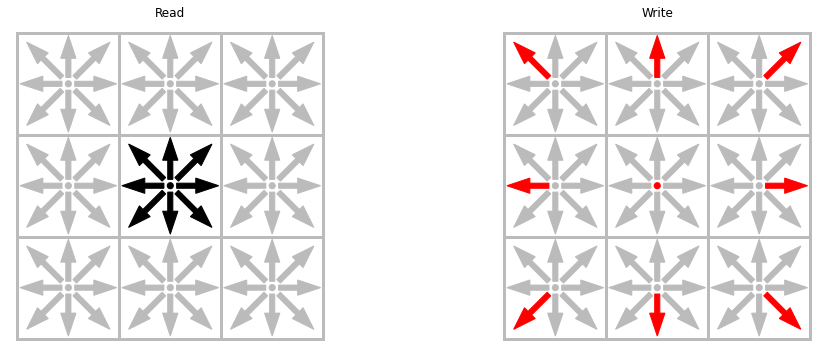

In [4]:
push_pattern = StreamPushTwoFieldsAccessor()
visualize_pdf_field_accessor(push_pattern)

## Esoteric Twist

 [Esoteric Twist: An Efficient in-Place Streaming Algorithmus for the Lattice Boltzmann Method on Massively Parallel Hardware](https://doi.org/10.3390/computation5020019)

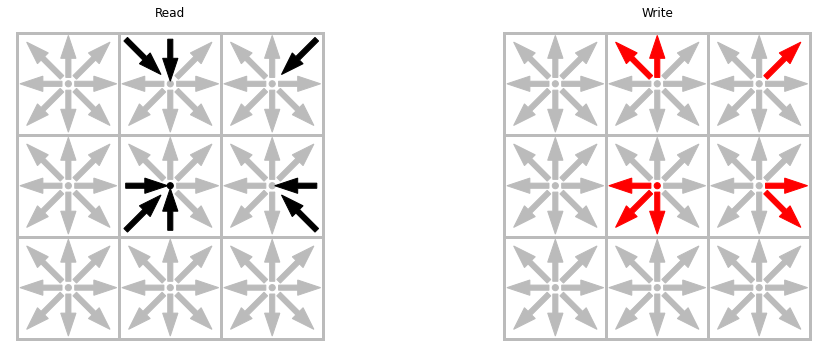

In [5]:
eso_odd = EsoTwistOddTimeStepAccessor()
visualize_pdf_field_accessor(eso_odd)

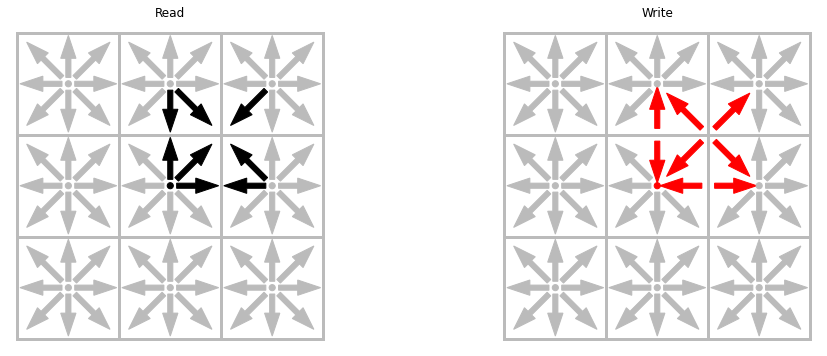

In [6]:
eso_even = EsoTwistEvenTimeStepAccessor()
visualize_pdf_field_accessor(eso_even)

## Esoteric Pull

 [Esoteric Pull and Esoteric Push: Two Simple In-Place Streaming Schemes for the Lattice Boltzmann Method on GPUs](https://doi.org/10.3390/computation5020019)

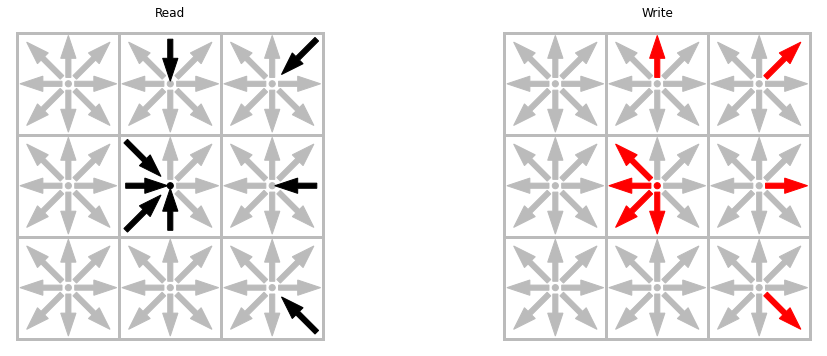

In [7]:
eso_pull_odd = EsoPullOddTimeStepAccessor()
visualize_pdf_field_accessor(eso_pull_odd)

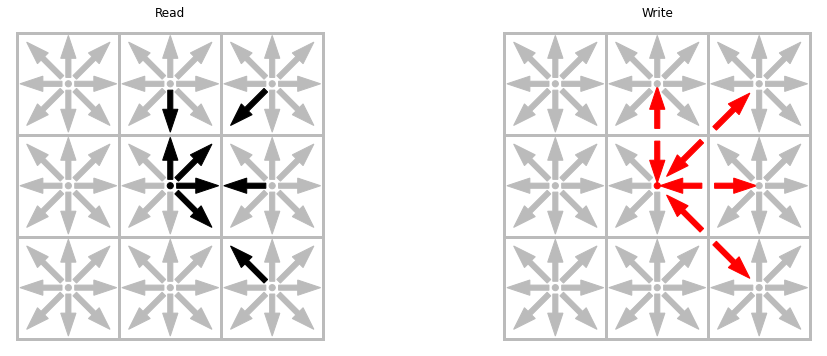

In [8]:
eso_pull_even = EsoPullEvenTimeStepAccessor()
visualize_pdf_field_accessor(eso_pull_even)

## Esoteric Push

 [Esoteric Pull and Esoteric Push: Two Simple In-Place Streaming Schemes for the Lattice Boltzmann Method on GPUs](https://doi.org/10.3390/computation5020019)

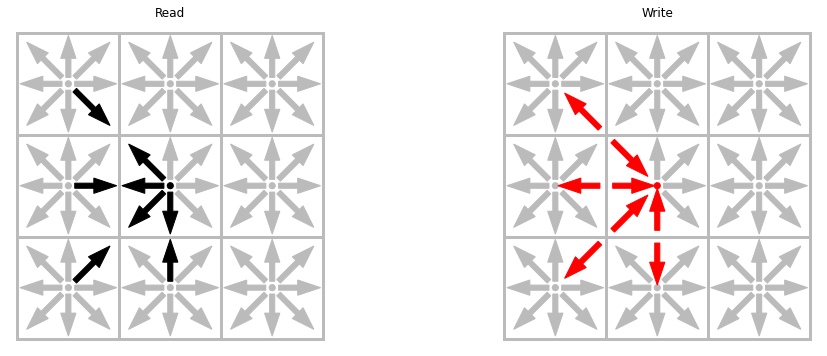

In [9]:
eso_push_odd = EsoPushOddTimeStepAccessor()
visualize_pdf_field_accessor(eso_push_odd)

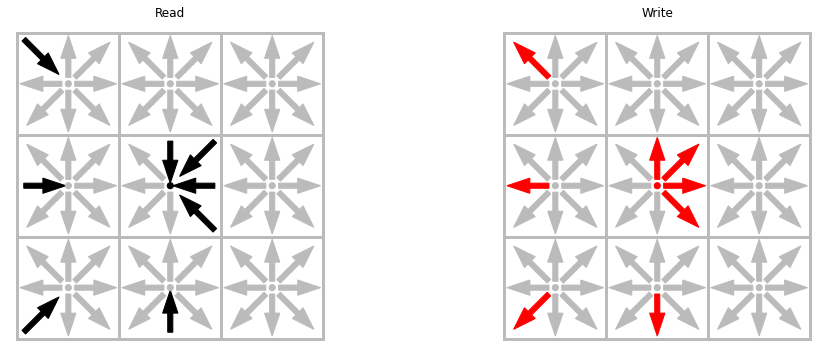

In [10]:
eso_push_even = EsoPushEvenTimeStepAccessor()
visualize_pdf_field_accessor(eso_push_even)

## AA Pattern

[Accelerating Lattice Boltzmann Fluid Flow Simulations Using Graphics Processors](https://doi.org/10.1109/ICPP.2009.38)

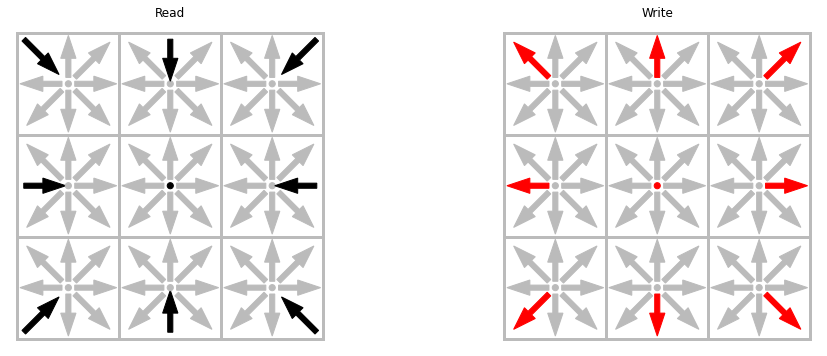

In [11]:
aa_odd = AAOddTimeStepAccessor()
visualize_pdf_field_accessor(aa_odd)

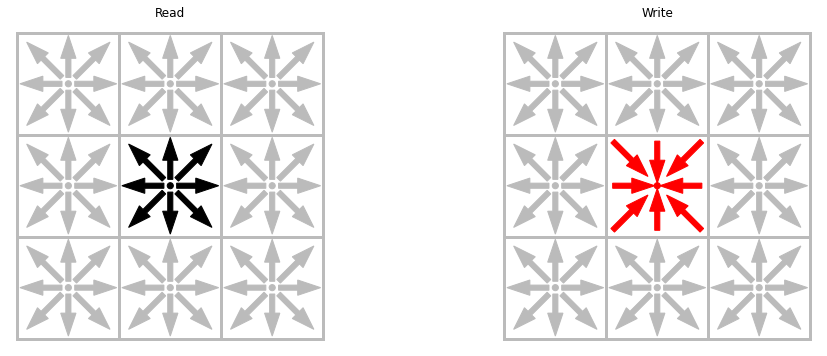

In [12]:
aa_even = AAEvenTimeStepAccessor()
visualize_pdf_field_accessor(aa_even)

## Streaming Patterns in Practice

As a next step, we will apply the different streaming patterns to a Lid-driven-cavity problem. Most of the steps are already shown in previous tutorials. Thus these should be used as a reference for setting up simulations in `lbmpy` in general. The main difference is that the `streaming_pattern` keyword will be passed to all top-level functions.

In [13]:
omega = 1.9

stencil = LBStencil(Stencil.D2Q9)
domain_size = (100, 100)
dim = len(domain_size)

streaming_pattern = 'esotwist'  # pull push aa esotwist esopull esopush
timesteps = get_timesteps(streaming_pattern) # [EVEN, ODD] for in-place patterns, [BOTH] for one-field patterns
zeroth_timestep = timesteps[0]
current_timestep = zeroth_timestep # at the beginning current timestep is zeroth timestep

In [14]:
dh = ps.create_data_handling(domain_size=domain_size)

pdfs = dh.add_array('pdfs', values_per_cell=stencil.Q)
dh.fill('pdfs', 0.0, ghost_layers=True)

if not is_inplace(streaming_pattern):
    pdfs_tmp = dh.add_array('pdfs_tmp', values_per_cell=stencil.Q)
    dh.fill('pdfs_tmp', 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=stencil.D)
dh.fill('velField', 0.0, ghost_layers=True)

densityField = dh.add_array('densityField', values_per_cell=1)
dh.fill('densityField', 1.0, ghost_layers=True)

In [15]:
output = {'density': densityField, 'velocity': velField}

lbm_config = LBMConfig(stencil=Stencil.D2Q9, method=Method.CUMULANT, relaxation_rate=omega,
                       compressible=True, field_name='pdfs',
                       output=output, streaming_pattern=streaming_pattern)

method = create_lb_method(lbm_config=lbm_config)
method

In [16]:
init = pdf_initialization_assignments(method, densityField, velField, pdfs,
                                      streaming_pattern=streaming_pattern, previous_timestep=zeroth_timestep)

ast_init = ps.create_kernel(init, target=dh.default_target)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)

In [17]:
if is_inplace(streaming_pattern):
    lbm_optimisation = LBMOptimisation(symbolic_field=pdfs)
else:
    lbm_optimisation = LBMOptimisation(symbolic_field=pdfs,
                                       symbolic_temporary_field=pdfs_tmp)


collision_rule = create_lb_collision_rule(lbm_config=lbm_config,
                                          lbm_optimisation=lbm_optimisation)

In [18]:
even_lbm_config = replace(lbm_config, timestep=Timestep.EVEN)
update_even = create_lb_update_rule(lbm_config=even_lbm_config, lbm_optimisation=lbm_optimisation)
ast_kernel_even = ps.create_kernel(update_even, target=dh.default_target, cpu_openmp=True)
kernel_even = ast_kernel_even.compile()

if is_inplace(streaming_pattern):
    odd_lbm_config = replace(lbm_config, timestep=Timestep.ODD)
    update_odd = create_lb_update_rule(lbm_config=odd_lbm_config, lbm_optimisation=lbm_optimisation)
    ast_kernel_odd = ps.create_kernel(update_odd, target=dh.default_target, cpu_openmp=True)
    kernel_odd = ast_kernel_odd.compile()
else:
    kernel_odd = kernel_even
    
lb_kernels = [kernel_even, kernel_odd]

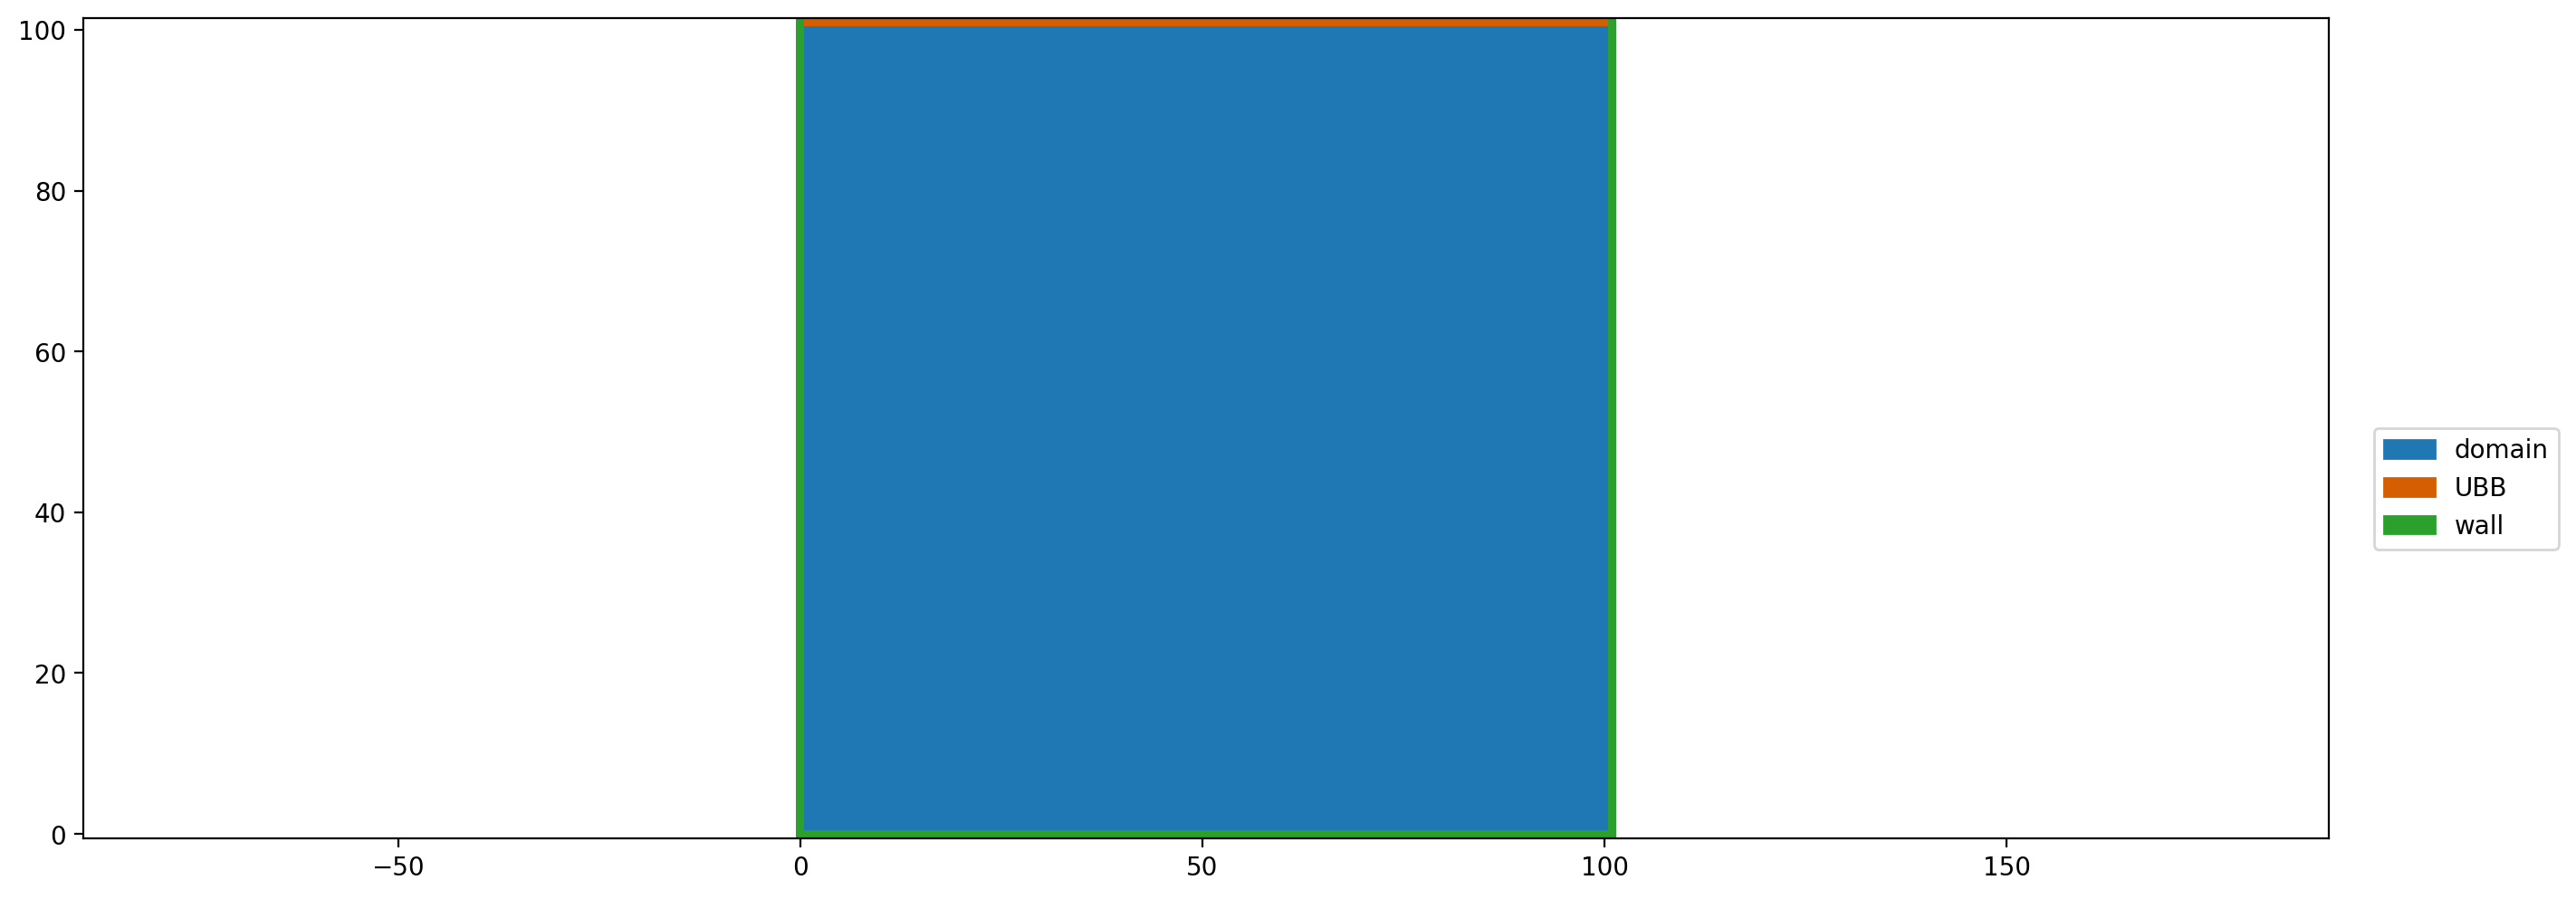

In [19]:
bh = LatticeBoltzmannBoundaryHandling(method, dh, 'pdfs', streaming_pattern=streaming_pattern)

moving_wall = UBB((0.05, 0))
wall = NoSlip("wall")

bh.set_boundary(moving_wall, slice_from_direction('N', dim))
for direction in ('E', 'S', 'W'):
    bh.set_boundary(wall, slice_from_direction(direction, dim))

plt.figure(dpi=200)
plt.boundary_handling(bh)

In [20]:
if is_inplace(streaming_pattern):
    def timeloop(timeSteps):
        global current_timestep
        for i in range(timeSteps):
            bh(prev_timestep=current_timestep)
            current_timestep = current_timestep.next()
            dh.run_kernel(lb_kernels[current_timestep.idx])
else:
    def timeloop(timeSteps):
        global current_timestep
        for i in range(timeSteps):
            bh(prev_timestep=current_timestep)
            current_timestep = current_timestep.next()
            dh.run_kernel(lb_kernels[current_timestep.idx])
            dh.swap("pdfs", "pdfs_tmp")

In [21]:
if 'is_test_run' not in globals():
    def run():
        timeloop(100)
        return dh.gather_array('velField')

    animation = plt.vector_field_magnitude_animation(run, frames=300, rescale=True)
    set_display_mode('video')
    res = display_animation(animation)
else:
    timeloop(10)
    res = None
res